In [ ]:
# # Install required libraries
# !pip install -U transformers datasets torch scikit-learn sentence-transformers faiss-cpu matplotlib seaborn

In [ ]:
import os
from getpass import getpass
import pandas as pd
import torch
from torch.nn.functional import softmax
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import normalize_embeddings
import faiss
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    classification_report
)
from datasets import Dataset

In [ ]:
# Hugging Face setup
HF_TOKEN = getpass("HF Token:")
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HF_TOKEN

HF Token:··········


In [ ]:
# Load and preprocess data
data = pd.read_csv("/content/balanced_news_dataset_1000.csv")

# Check label distribution
print("Label distribution in dataset:")
print(data['label'].value_counts())

Label distribution in dataset:
label
1    500
0    500
Name: count, dtype: int64


In [ ]:
# Ensure stratified split to maintain label distribution
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['title'],
    data['label'],
    test_size=0.2,
    random_state=42,
    stratify=data['label']  # Ensure proportional representation of classes
)

# Verify test set label distribution
print("\nLabel distribution in test set:")
print(pd.Series(test_labels).value_counts())


Label distribution in test set:
label
1    100
0    100
Name: count, dtype: int64


In [ ]:
# Initialize sentence transformer for embeddings
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Compute embeddings for vector database
database_embeddings = sentence_model.encode(data['title'].tolist(), convert_to_tensor=True)
database_embeddings = normalize_embeddings(database_embeddings)

In [ ]:
# Build FAISS index
dimension = database_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(database_embeddings.cpu().numpy())

In [ ]:
# Tokenization setup for classification model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [ ]:
# Create Hugging Face datasets
train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# Initialize classification model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define compute_metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

In [ ]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Train and save model
trainer.train()
trainer.save_model('trained_model')
tokenizer.save_pretrained('tokenizer')

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lochan-paudel-btech2023 (lochan-paudel-btech2023-symbiosis-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.350225,0.880000
2,No log,0.251175,0.905000
3,No log,0.273680,0.890000
4,No log,0.318277,0.895000
5,No log,0.339792,0.890000
6,No log,0.358437,0.890000


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [ ]:
# Evaluate model
results = trainer.evaluate()
print(f"Final accuracy: {results['eval_accuracy']:.2%}")

Final accuracy: 89.00%


In [ ]:
# Get predictions for evaluation
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
labels = predictions.label_ids
probs = softmax(torch.tensor(logits), dim=1).numpy()
predicted_labels = np.argmax(probs, axis=1)

Confusion Matrix:
[[90 10]
 [12 88]]
ROC-AUC: 0.9671
Average Precision: 0.9607
Classification Report:
              precision    recall  f1-score   support

        Fake       0.88      0.90      0.89       100
        Real       0.90      0.88      0.89       100

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



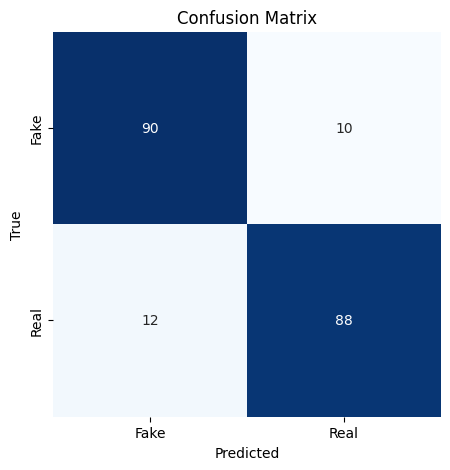

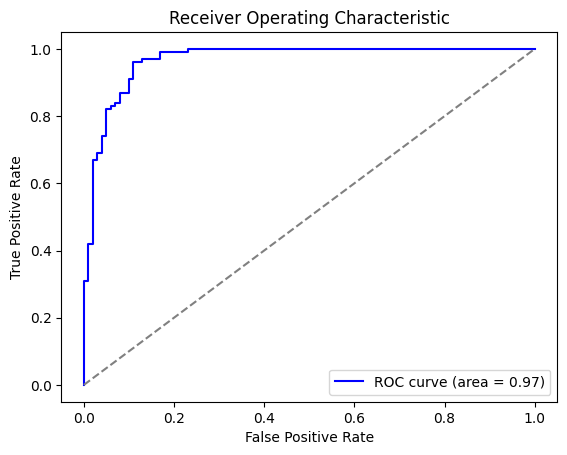

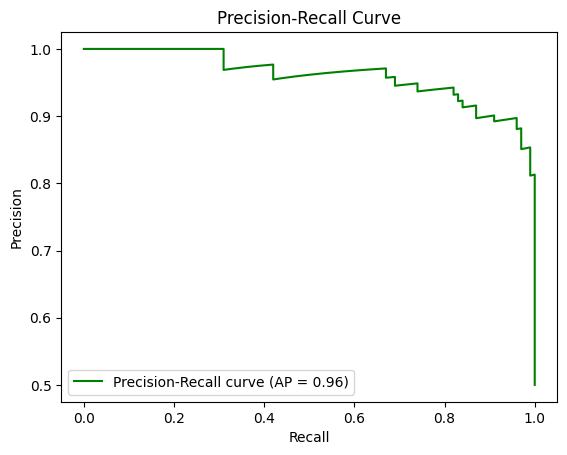

In [ ]:
# Check if test set has both classes
unique_labels = np.unique(labels)
if len(unique_labels) < 2:
    print("Warning: Test set contains only one class. Some metrics may not be computable.")
    print("Accuracy:", accuracy_score(labels, predicted_labels))
    print("Confusion Matrix:")
    cm = confusion_matrix(labels, predicted_labels, labels=[0, 1])  # Explicitly define labels
    print(cm)
else:
    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_labels, labels=[0, 1])
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')

    # ROC-AUC
    fpr, tpr, _ = roc_curve(labels, probs[:,1])
    roc_auc = auc(fpr, tpr)
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig('roc_curve.png')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(labels, probs[:,1])
    ap = average_precision_score(labels, probs[:,1])
    print(f"Average Precision: {ap:.4f}")

    # Plot Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, color='green', label=f'Precision-Recall curve (AP = {ap:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.savefig('precision_recall_curve.png')

    # Classification Report
    report = classification_report(labels, predicted_labels, target_names=['Fake', 'Real'], labels=[0, 1])
    print("Classification Report:")
    print(report)

In [ ]:

# Learning Curves
log_history = trainer.state.log_history
eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_accuracies = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]
epochs = [log['epoch'] for log in log_history if 'eval_loss' in log]

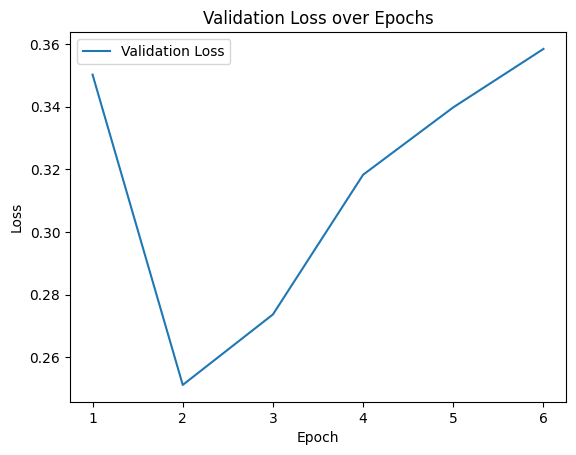

In [ ]:
# Plot validation loss
plt.figure()
plt.plot(epochs, eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.savefig('validation_loss.png')

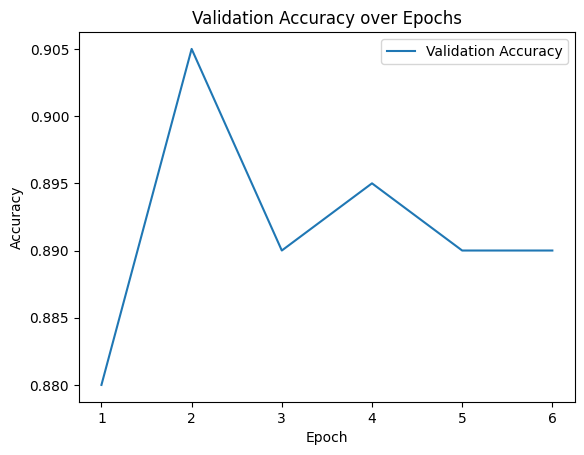

In [ ]:
# Plot validation accuracy
plt.figure()
plt.plot(epochs, eval_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.savefig('validation_accuracy.png')

In [ ]:
# RAG-enhanced classify_news function
SIMILARITY_THRESHOLD = 0.2  # Adjust based on validation

In [ ]:
def classify_news(text):
    # Compute embedding for similarity search
    input_embedding = sentence_model.encode([text], convert_to_tensor=True)
    input_embedding = normalize_embeddings(input_embedding)

    # Search vector database
    distances, indices = index.search(input_embedding.cpu().numpy(), k=1)
    similarity = distances[0][0]

    if similarity < SIMILARITY_THRESHOLD:
        return {
            "prediction": 3,
            "explanation": "It's out of context as no similar news was found in the database."
        }

    # Use classification model
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = softmax(logits, dim=1)
    max_prob, predicted_class = torch.max(probabilities, dim=1)

    # Get similar article for explanation
    similar_idx = indices[0][0]
    similar_title = data.iloc[similar_idx]['title']
    similar_label = data.iloc[similar_idx]['label']

    if predicted_class.item() == 1:
        prediction = 1
        label = "Real"
    else:
        prediction = 2
        label = "Fake"

    explanation = (f"Classified as {label}, similar to '{similar_title}' "
                  f"which is {'real' if similar_label == 1 else 'fake'} "
                  f"(similarity: {similarity:.2f}).")

    return {
        "prediction": prediction,
        "explanation": explanation
    }

In [ ]:
# Example usage
if __name__ == "__main__":
    example_texts = [
        "Rare accounts of life in el-Fasher - the last major city in Darfur controlled by the Sudanese army. The UK is promising an extra "
    ]

    for text in example_texts:
        result = classify_news(text)
        label = {1: "Real", 2: "Fake", 3: "Out of context"}[result["prediction"]]
        print(f"Text: {text}")
        print(f"Prediction: {label} ({result['prediction']})")
        print(f"Explanation: {result['explanation']}\n")

Text: Rare accounts of life in el-Fasher - the last major city in Darfur controlled by the Sudanese army. The UK is promising an extra 
Prediction: Fake (2)
Explanation: Classified as Fake, similar to 'Moscow, Riyadh work together to unite Syria's opposition: Saudi minister' which is real (similarity: 0.41).

